# Quantification

This notebook is a fast-forward version of local thickness analysis with focus on quantification.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tifffile
import skimage
import localthickness as lt

def lognormal_statistics(dist):
    log = np.log(dist)
    stats = {'mean': dist.mean(), 
             'median': np.exp(log.mean()), 
             'mode': np.exp(log.mean() - log.std()**2)
             }
    return stats

def central_slice(vol, ax=0):
    # returns central slice along axis ax
    s = vol.shape[ax]//2
    slicing = (slice(None), ) * ax + (slice(s, s+1),)
    return vol[slicing].squeeze(axis=ax)


In [2]:
# If needed, retrieve volume from QIM data repository. 
# This may take a couple of minutes, but is only done once.
import os
if not os.path.isdir('cement_data'):
    !wget -q https://qim.compute.dtu.dk/data-repository/cement_data.zip

    # Unzip the file to the current directory.
    import shutil
    shutil.unpack_archive('cement_data.zip', 'cement_data')

## Segmentation

A simple binarization pipeline consisting of Gaussian smoothing, thresholding and morphological filtering. 

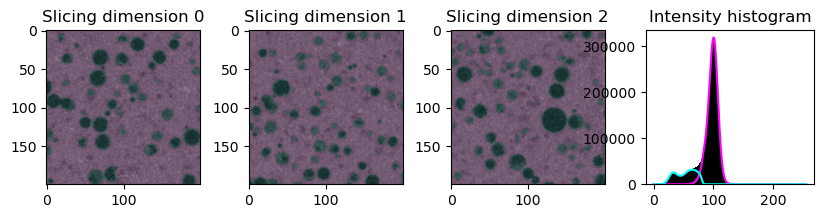

Material density 82%.


In [3]:
# Binarization parameters
smoothing_sigma = 0.5
threshold = 80
morphology_radius = 2

# Load, crop and binarize the volume.
vol = tifffile.imread('cement_data/cement2.tif')
vol = vol[300:500, 200:400, 300:500]

# Binarization: gaussian smoothing, thresholding, morphology
bin_vol = skimage.filters.gaussian(vol.astype(float)/255, sigma=smoothing_sigma)
bin_vol = bin_vol > threshold/255
bin_vol = skimage.morphology.binary_closing(bin_vol, skimage.morphology.ball(morphology_radius))

# Look at binarization of three orthogonal cross-sections and histogram.
fig, ax = plt.subplots(1, 4, figsize=(10, 2))
for i in range(3):
    ax[i].imshow(central_slice(vol, i), cmap=plt.cm.gray, vmin=0, vmax=255)
    ax[i].imshow(central_slice(bin_vol, i), cmap=plt.cm.cool, alpha=0.1, vmin=0, vmax=1)
    ax[i].set_title(f'Slicing dimension {i}')

edges = np.arange(257)-0.5
centers= np.arange(256)
ax[3].bar(centers, np.histogram(vol.ravel(), edges)[0], width=1, color='k')
ax[3].plot(centers, np.histogram(vol[bin_vol], edges)[0], color=plt.cm.cool(1.))
ax[3].plot(centers, np.histogram(vol[~bin_vol], edges)[0], color=plt.cm.cool(0.))
ax[3].set_title('Intensity histogram')
plt.show()

print(f'Material density {100*bin_vol.sum()/bin_vol.size:.0f}%.')


## Local thickness (LT)

Local thickness is applied directly to binarized volume. No parameters required.

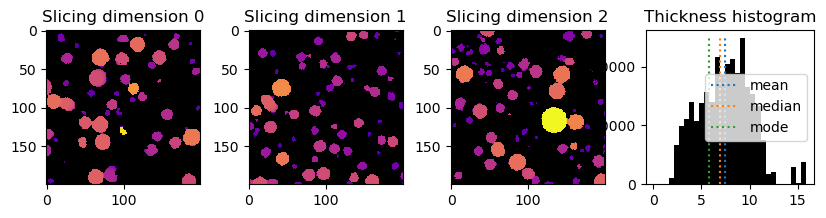

Thickness mean, median and mode 7.5, 6.9, 5.8.


In [4]:
th = lt.local_thickness(~bin_vol)
thmax = th.max()

th_hist, th_binedges = np.histogram(th[~bin_vol], 30, range=(0, thmax))
th_stats = lognormal_statistics(th[~bin_vol])

cmap = lt.black_plasma()
fig, ax = plt.subplots(1, 4, figsize=(10, 2))
for i in range(3):
    ax[i].imshow(central_slice(th, i), cmap=cmap, vmin=0, vmax=thmax, interpolation='nearest')
    ax[i].set_title(f'Slicing dimension {i}')
ax[3].bar(th_binedges[:-1], th_hist, width=th_binedges[1], align='edge', color='k')
ax[3].set_title('Thickness histogram')
for stats in th_stats.keys():
    ax[3].plot([th_stats[stats]]*2, [0, th_hist.max()], ':', label=stats)
ax[3].legend()
plt.show()

print(f"Thickness mean, median and mode {th_stats['mean']:.02g}, {th_stats['median']:.02g}, {th_stats['mode']:.02g}.")